In [1]:
from pathlib import Path
import pickle
from typing import Dict, List

import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np
from tqdm.auto import tqdm

from util.log_transform import log_transform_np

In [2]:
dir_path = Path("../data")
print([p.stem for p in dir_path.glob("*")])

['FlatFault_A', 'Style_A', 'CurveVel_B', 'FlatVel_A', 'CurveVel_A', 'CurveFault_A', 'CurveFault_B', 'FlatFault_B', 'FlatVel_B', 'Style_B']


### Check the number of dataset

In [3]:
families = {
    "CurveFault_A": [],
    "CurveFault_B": [],
    "CurveVel_A": ["data", "model"],
    "CurveVel_B": ["data", "model"],
    "FlatFault_A": [],
    "FlatFault_B": [],
    "FlatVel_A": ["data", "model"],
    "FlatVel_B": ["data", "model"],
    "Style_A": ["data", "model"],
    "Style_B": ["data", "model"], 
}

for k in families.keys():
    p = dir_path.joinpath(k)
    print(k, len([pp for pp in p.glob("*")]))

CurveFault_A 54000
CurveFault_B 54000
CurveVel_A 30000
CurveVel_B 30000
FlatFault_A 54000
FlatFault_B 54000
FlatVel_A 30000
FlatVel_B 30000
Style_A 67000
Style_B 67000


### Plot images

CurveFault_A seis4_1_3_vel4_1_3_25 (5, 1000, 70) (1, 70, 70)
-21.098043 40.047462 1617.0 4303.007


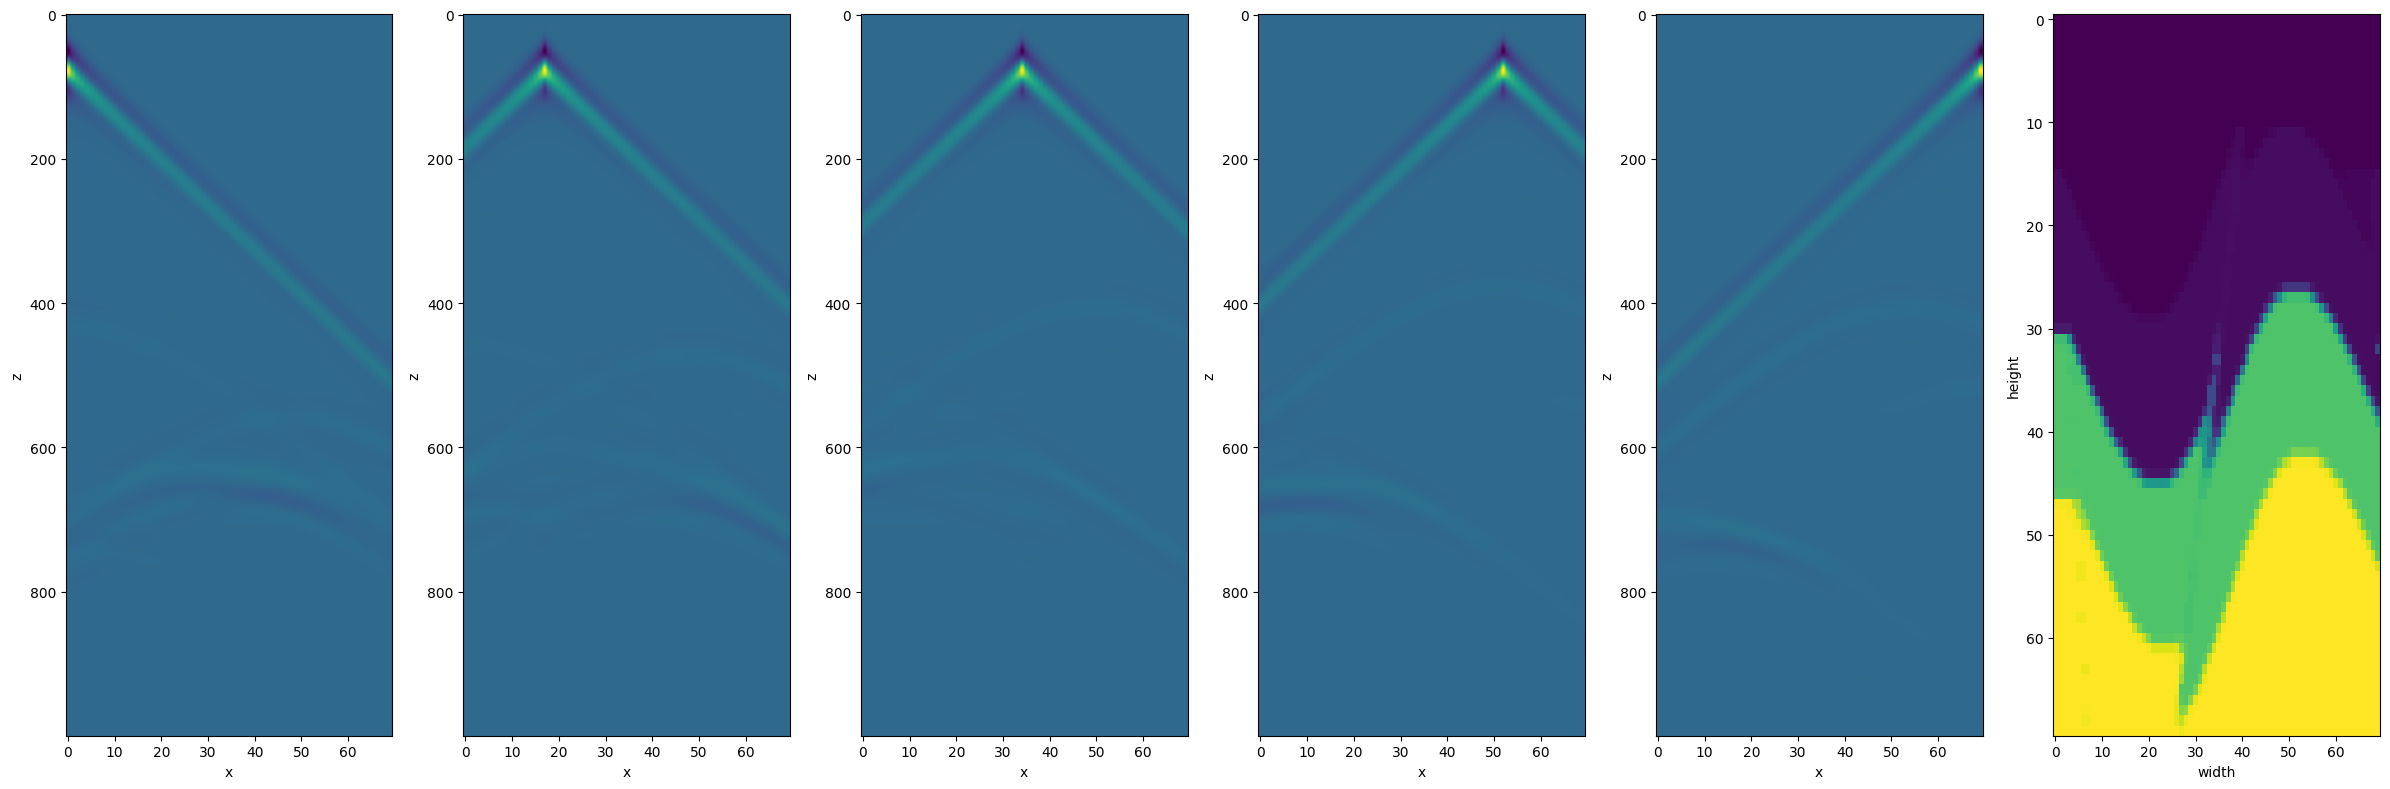

CurveFault_B seis8_1_18_vel8_1_18_400 (5, 1000, 70) (1, 70, 70)
-21.50076 40.84904 1513.0 4192.0


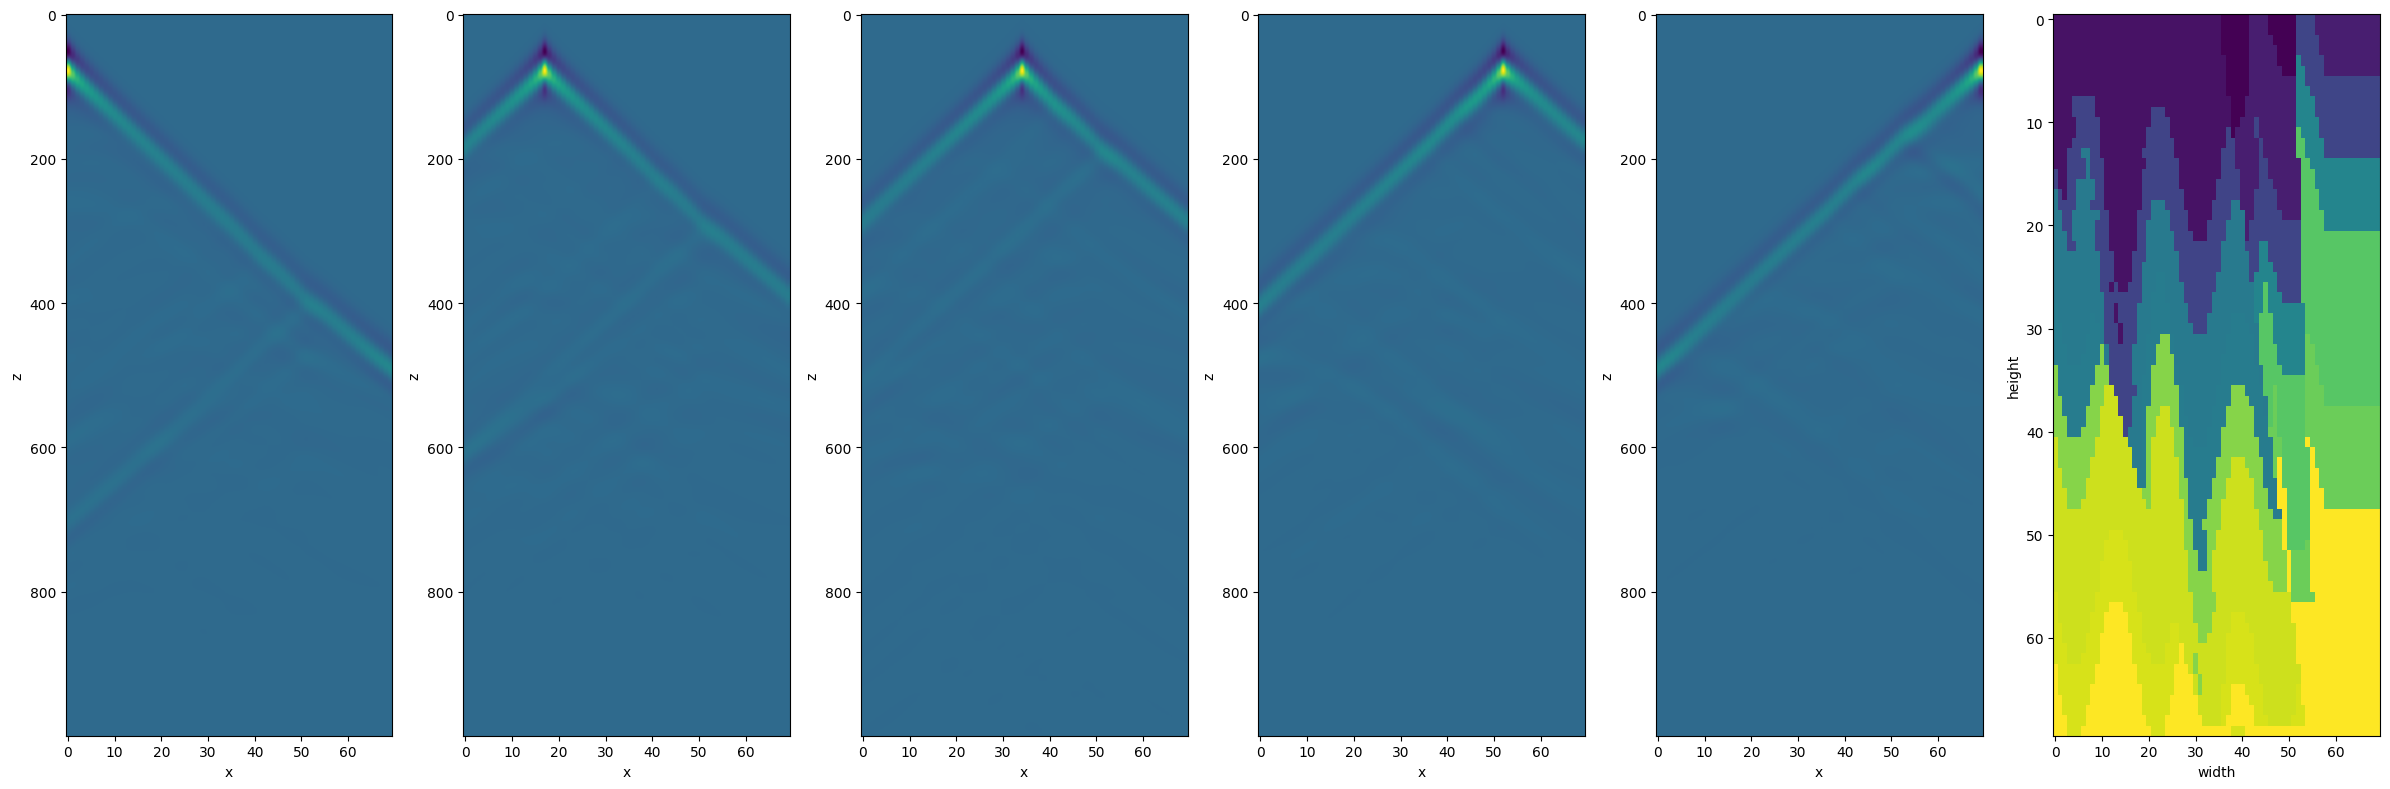

CurveVel_A data38_model38_220 (5, 1000, 70) (1, 70, 70)
-21.277191 40.41518 1671.0 4407.0


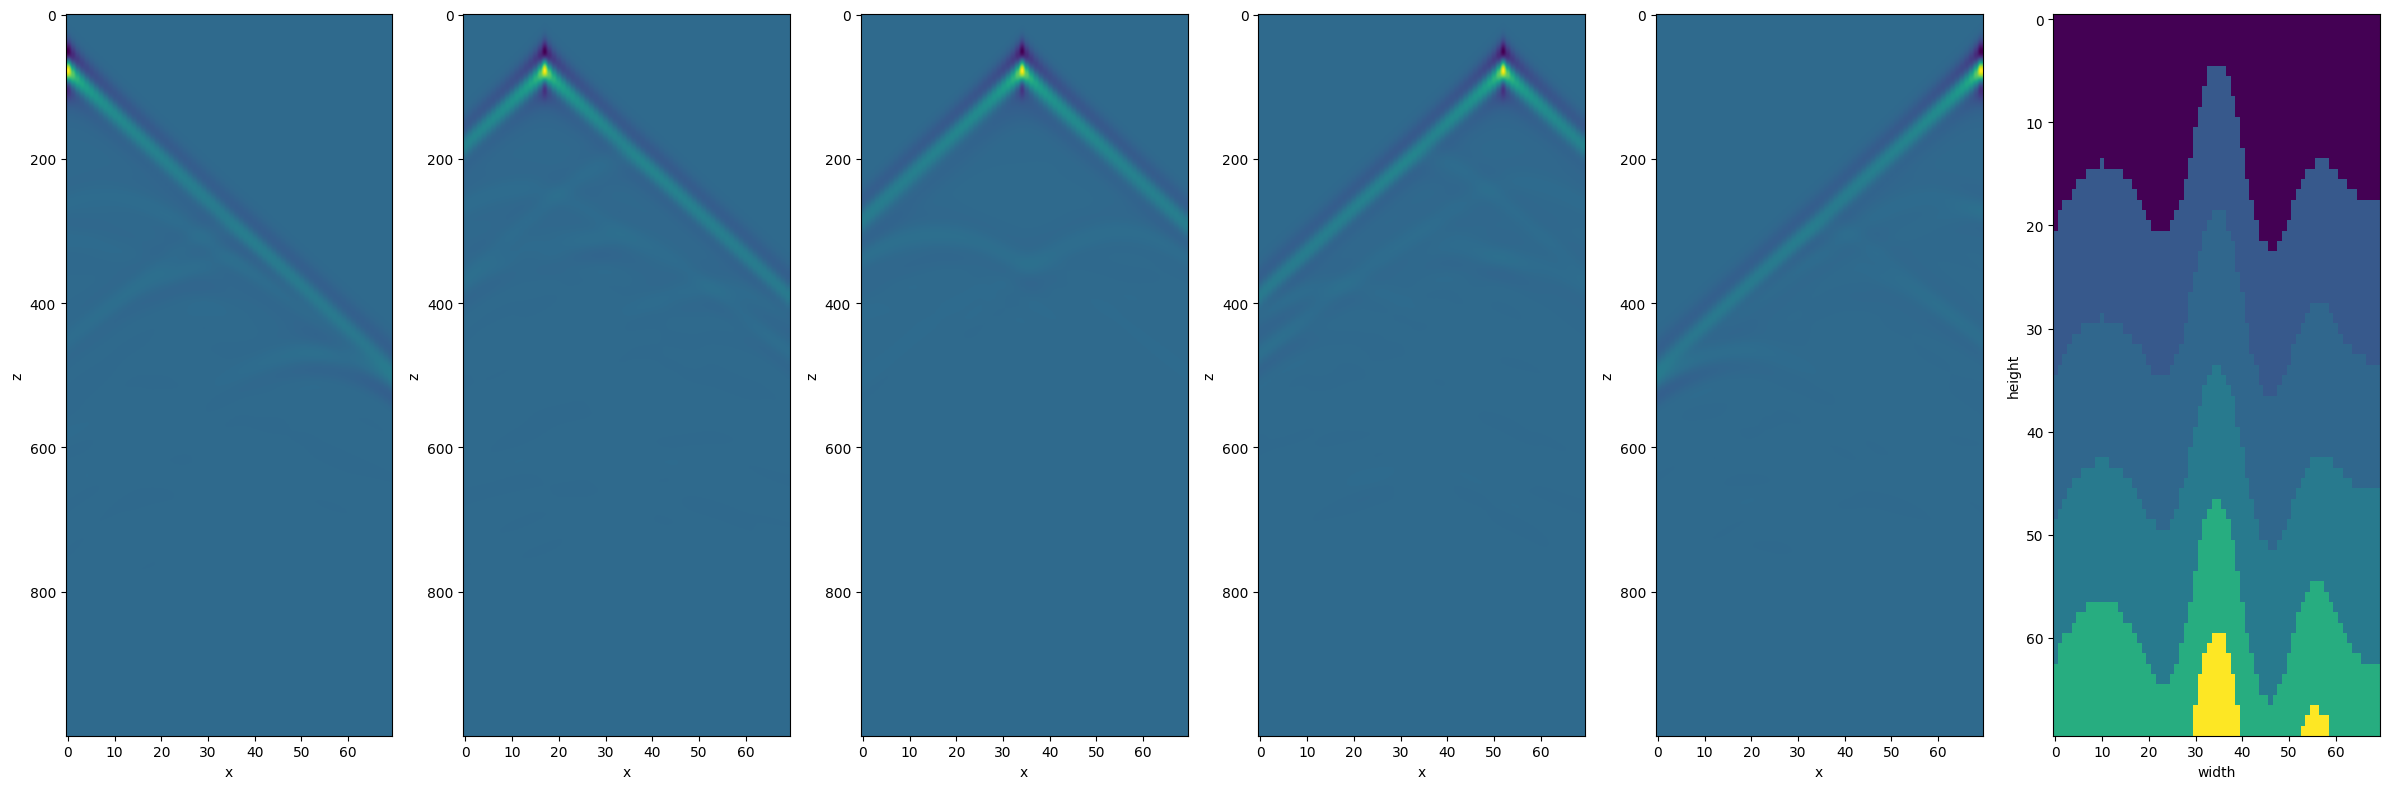

CurveVel_B data36_model36_250 (5, 1000, 70) (1, 70, 70)
-26.158012 50.963097 2066.0 3945.0


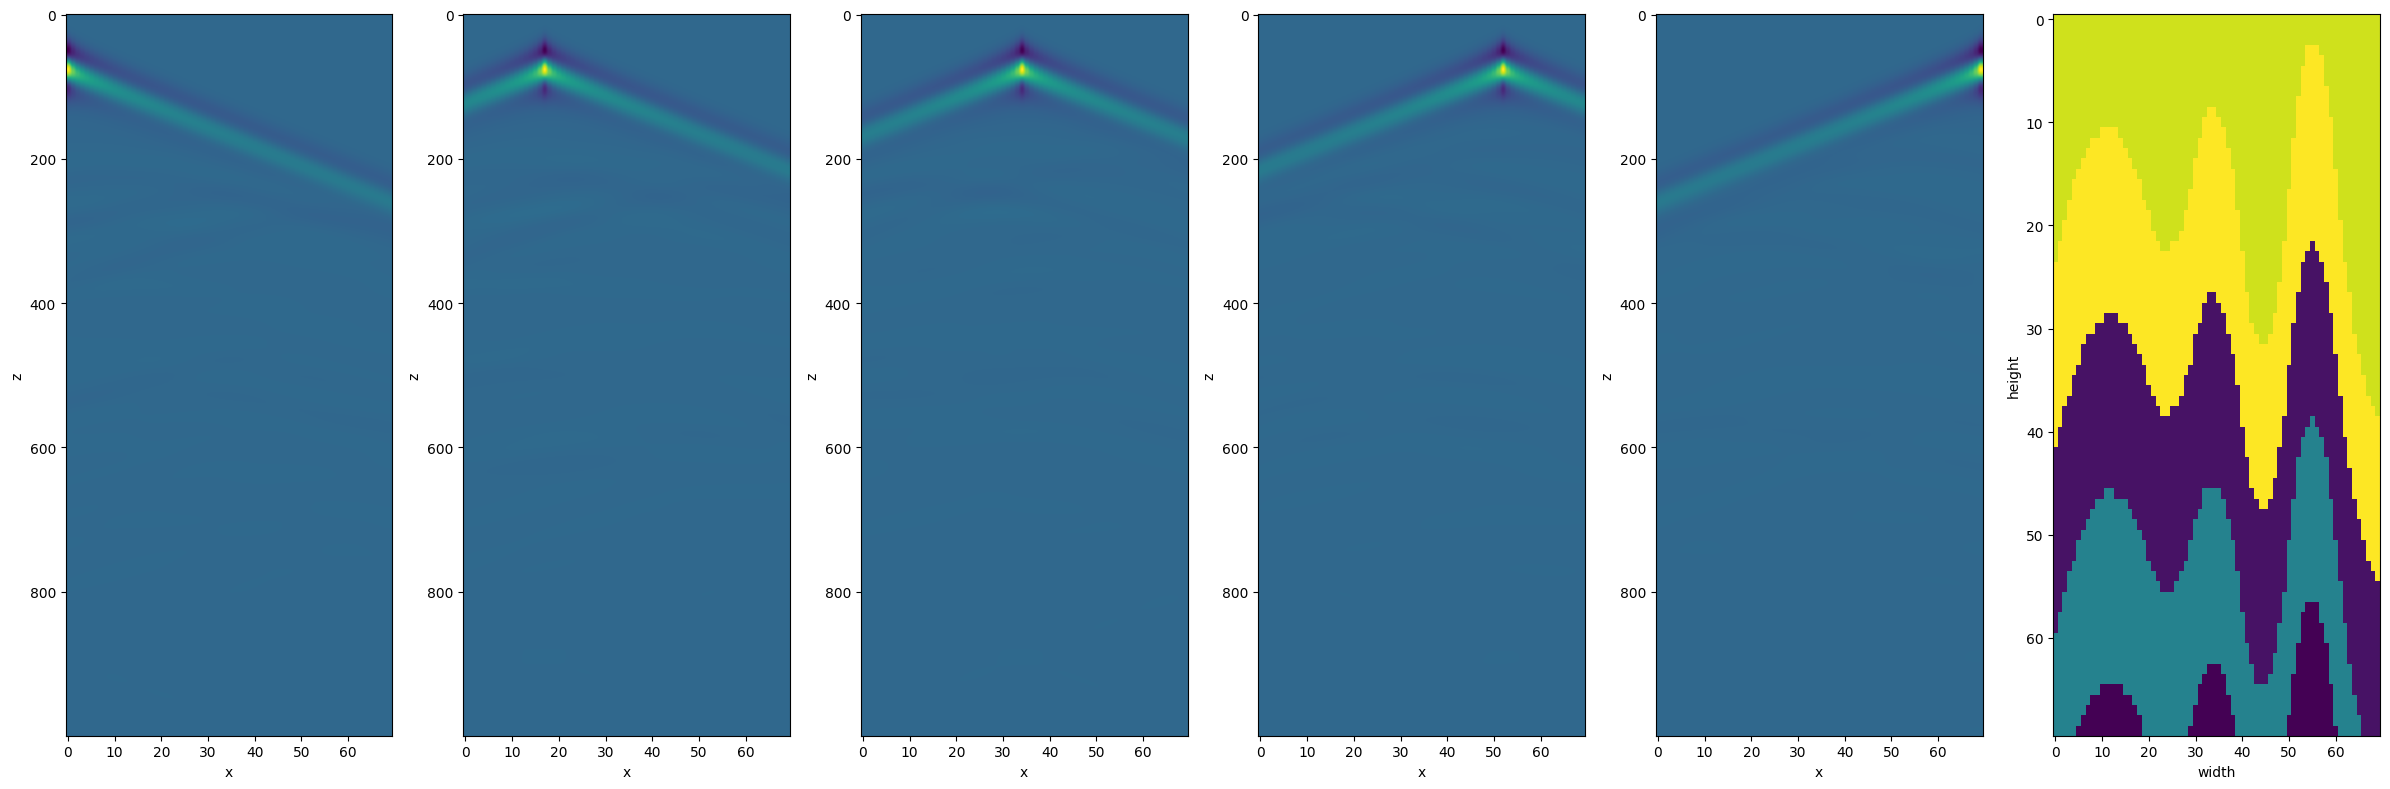

FlatFault_A seis3_1_34_vel3_1_34_426 (5, 1000, 70) (1, 70, 70)
-22.466038 42.939224 2077.0 4477.4507


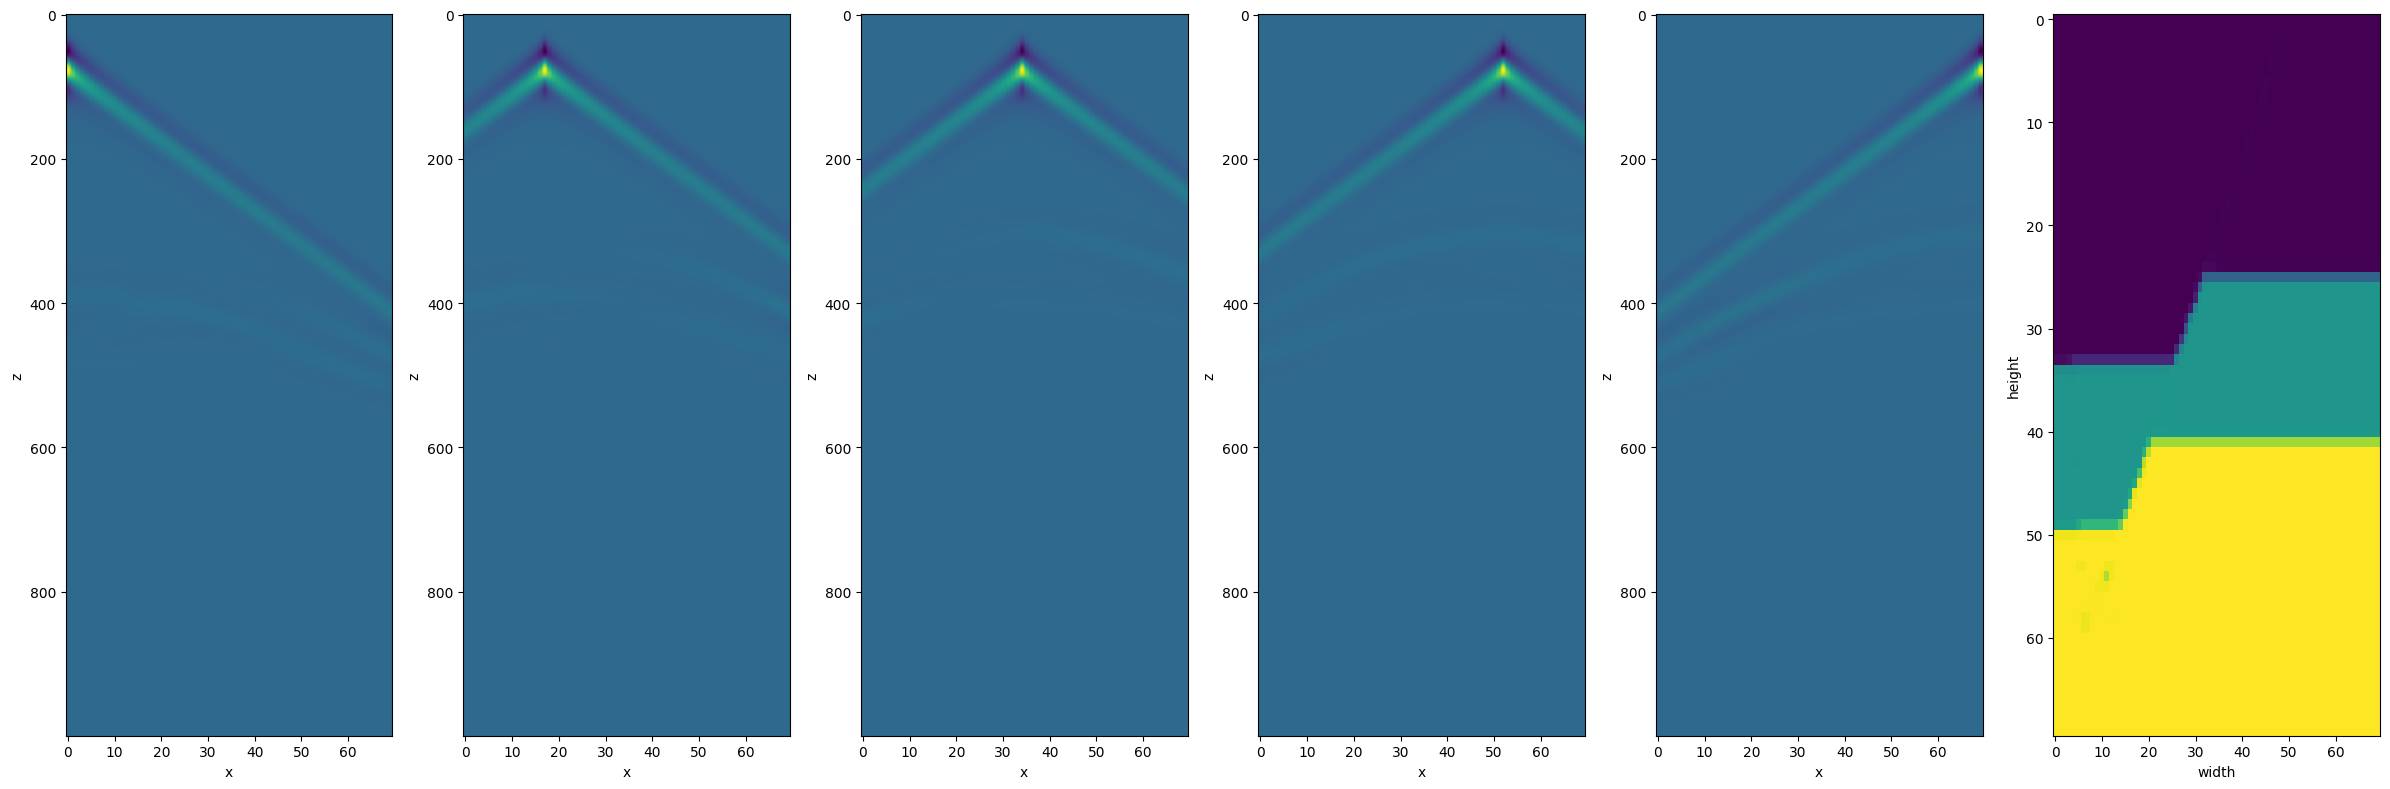

FlatFault_B seis6_1_1_vel6_1_1_328 (5, 1000, 70) (1, 70, 70)
-21.9836 41.321693 1690.0 4433.0


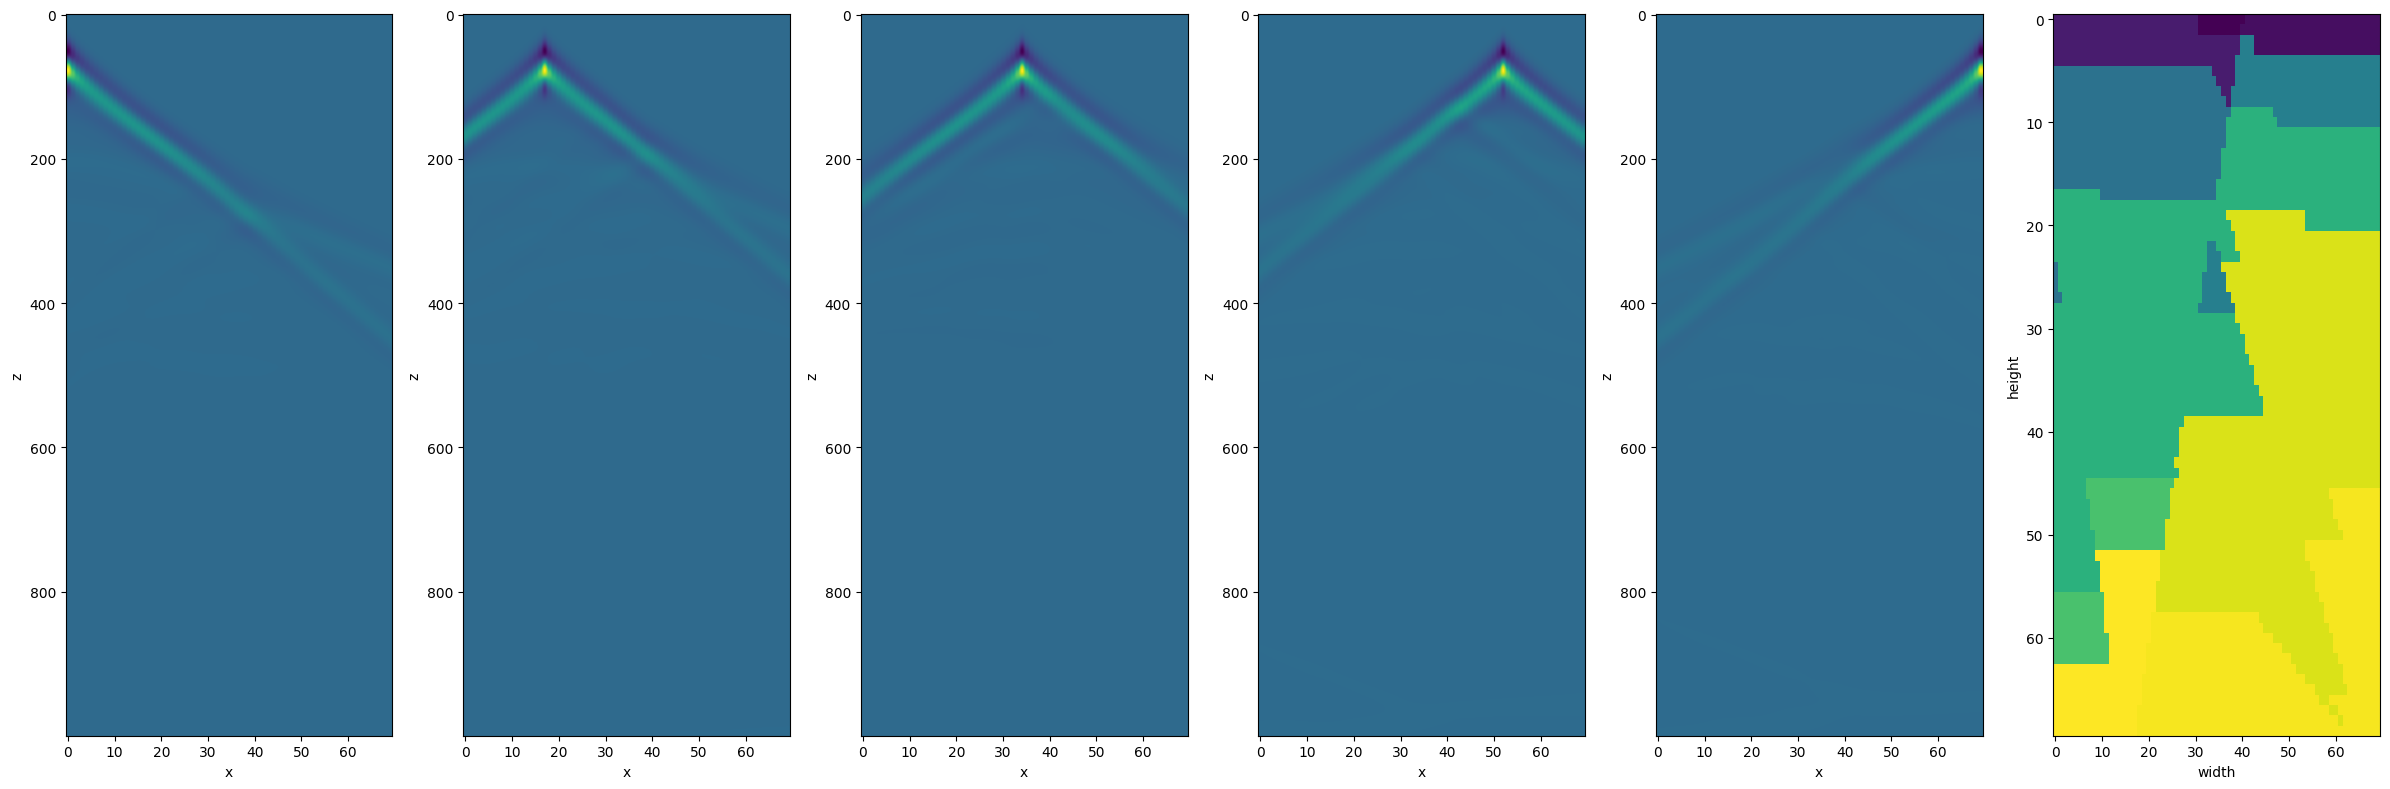

FlatVel_A data53_model53_284 (5, 1000, 70) (1, 70, 70)
-22.738337 43.57889 2184.0 3558.0


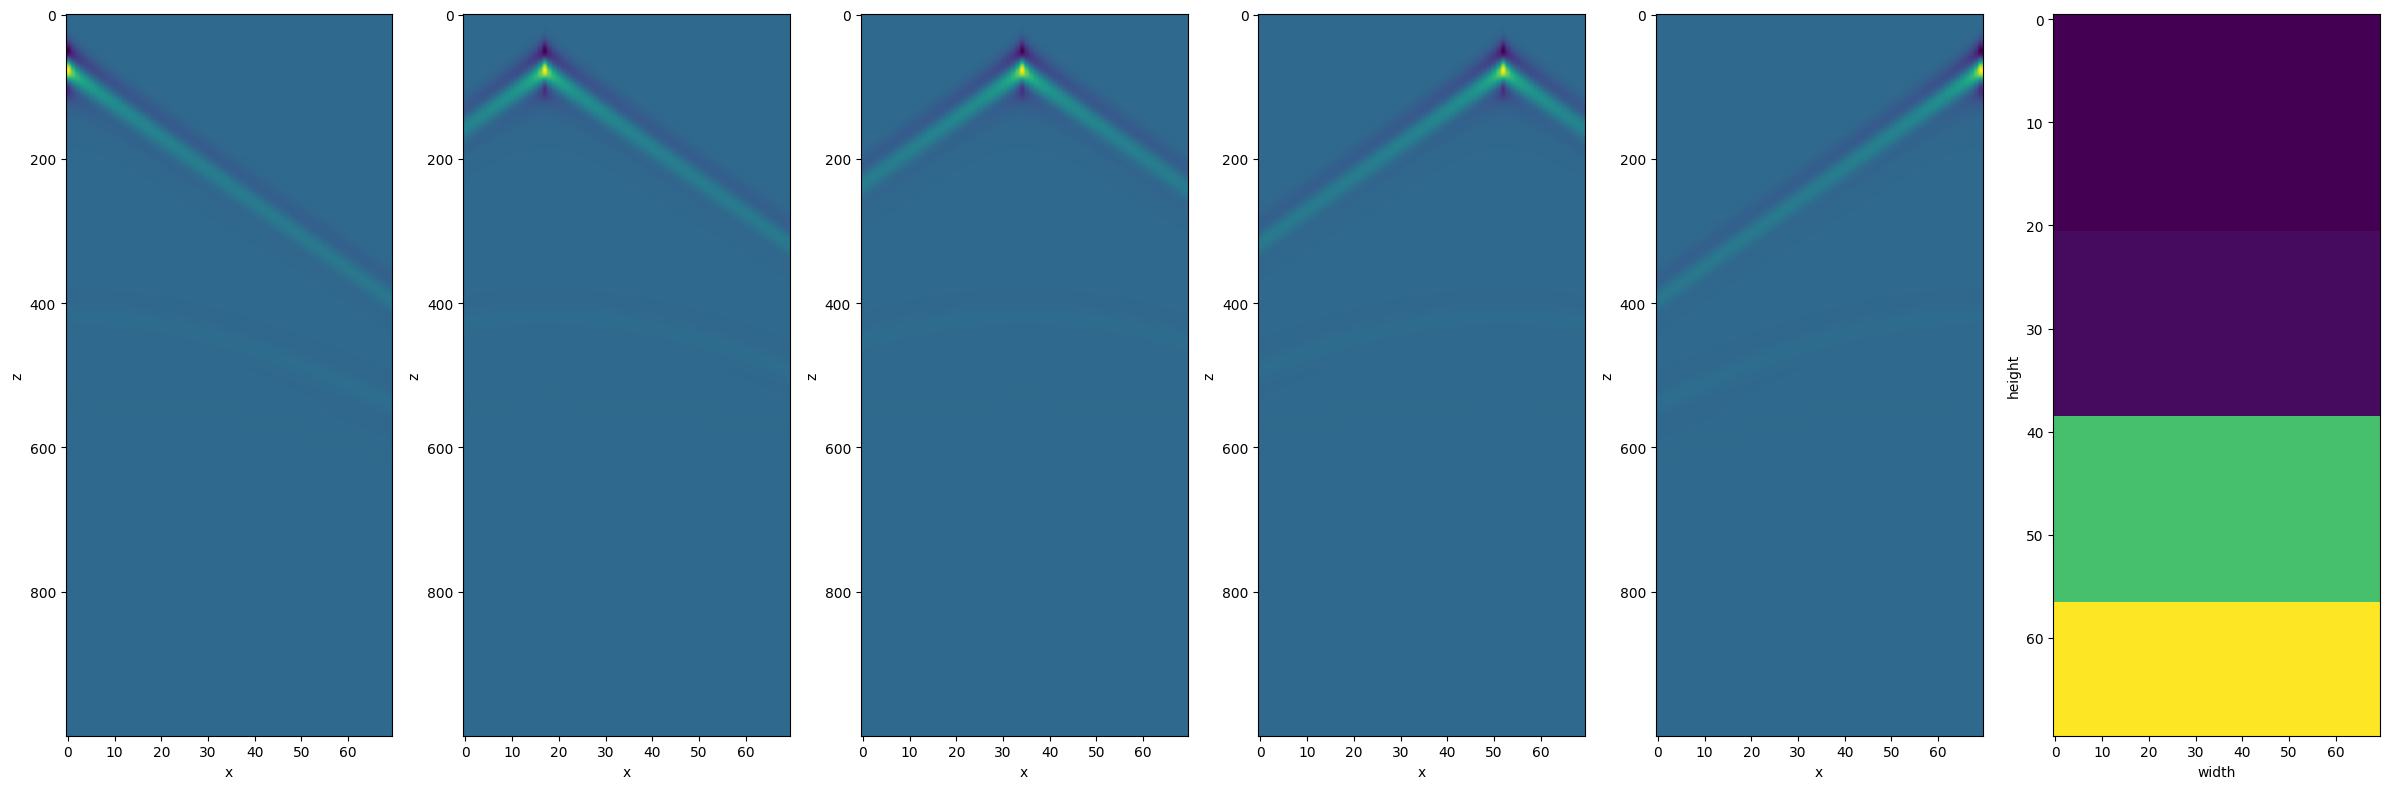

FlatVel_B data49_model49_85 (5, 1000, 70) (1, 70, 70)
-24.922983 48.303974 1946.0 4322.0


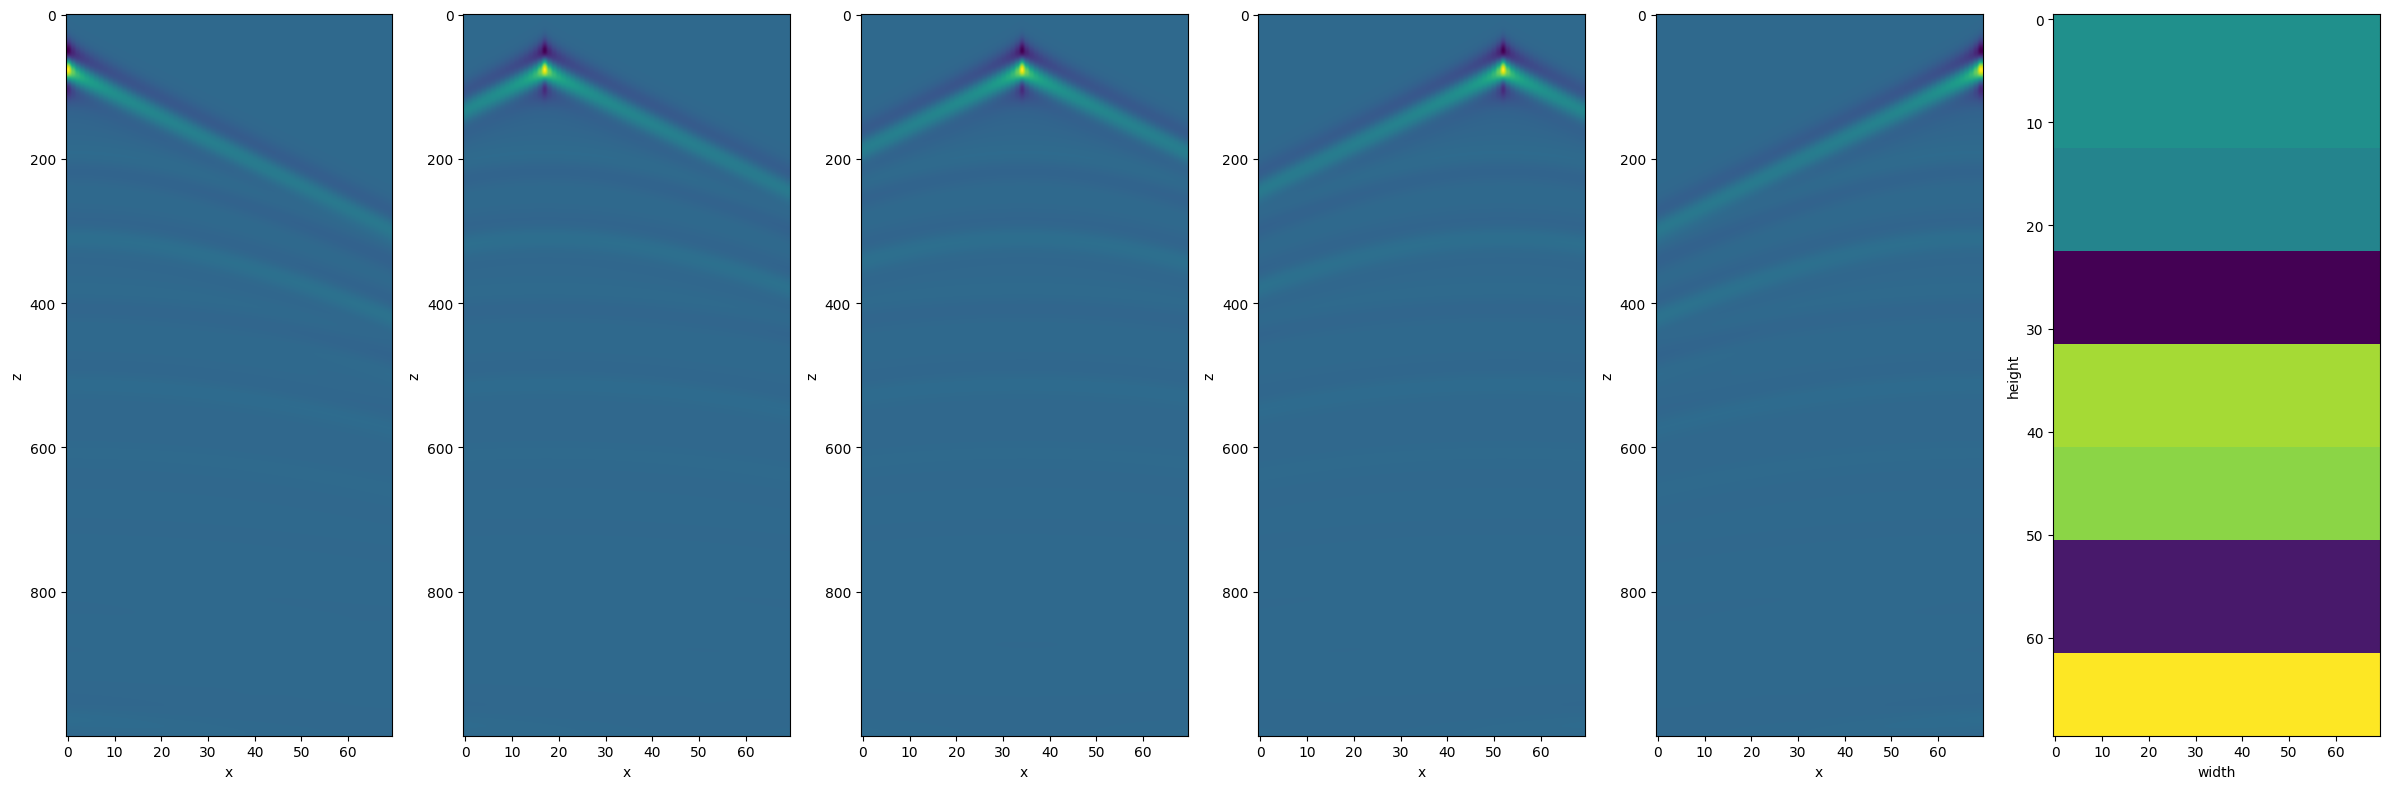

Style_A data63_model63_498 (5, 1000, 70) (1, 70, 70)
-21.435146 40.524857 1643.3983 3837.1746


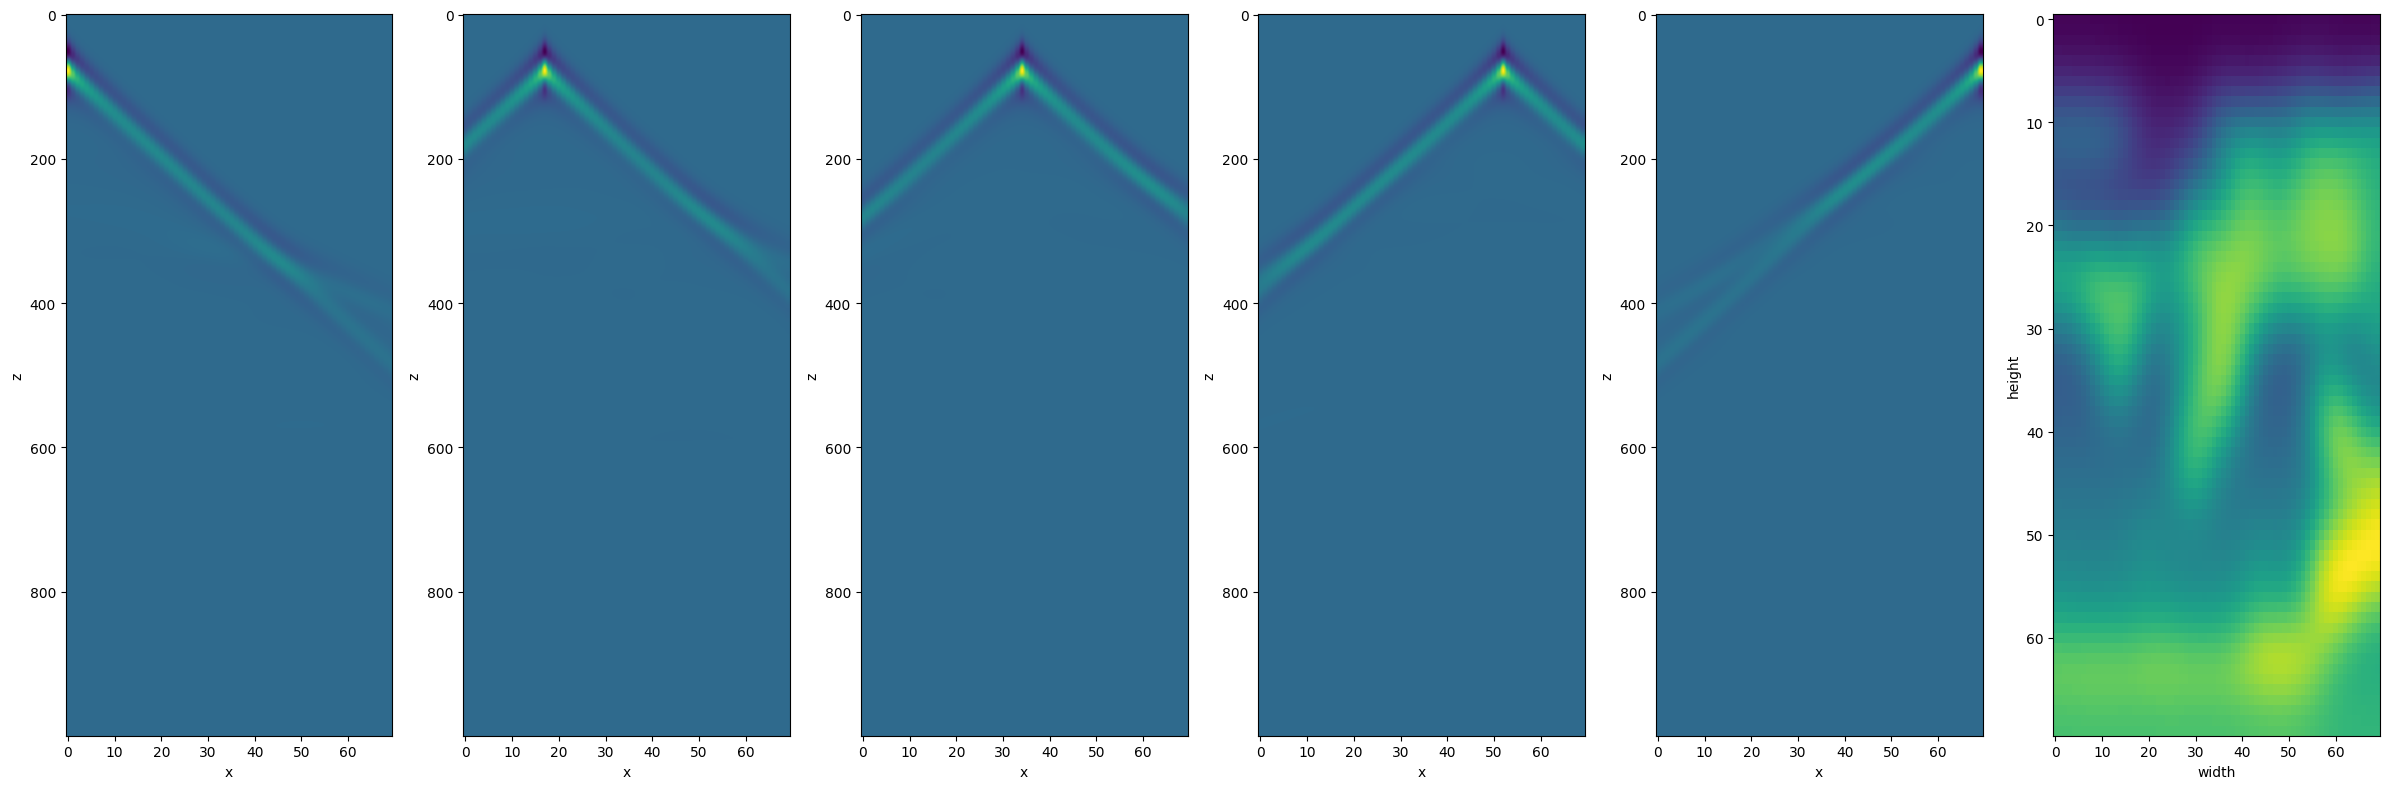

Style_B data54_model54_36 (5, 1000, 70) (1, 70, 70)
-22.599007 43.323166 1608.9344 4388.3013


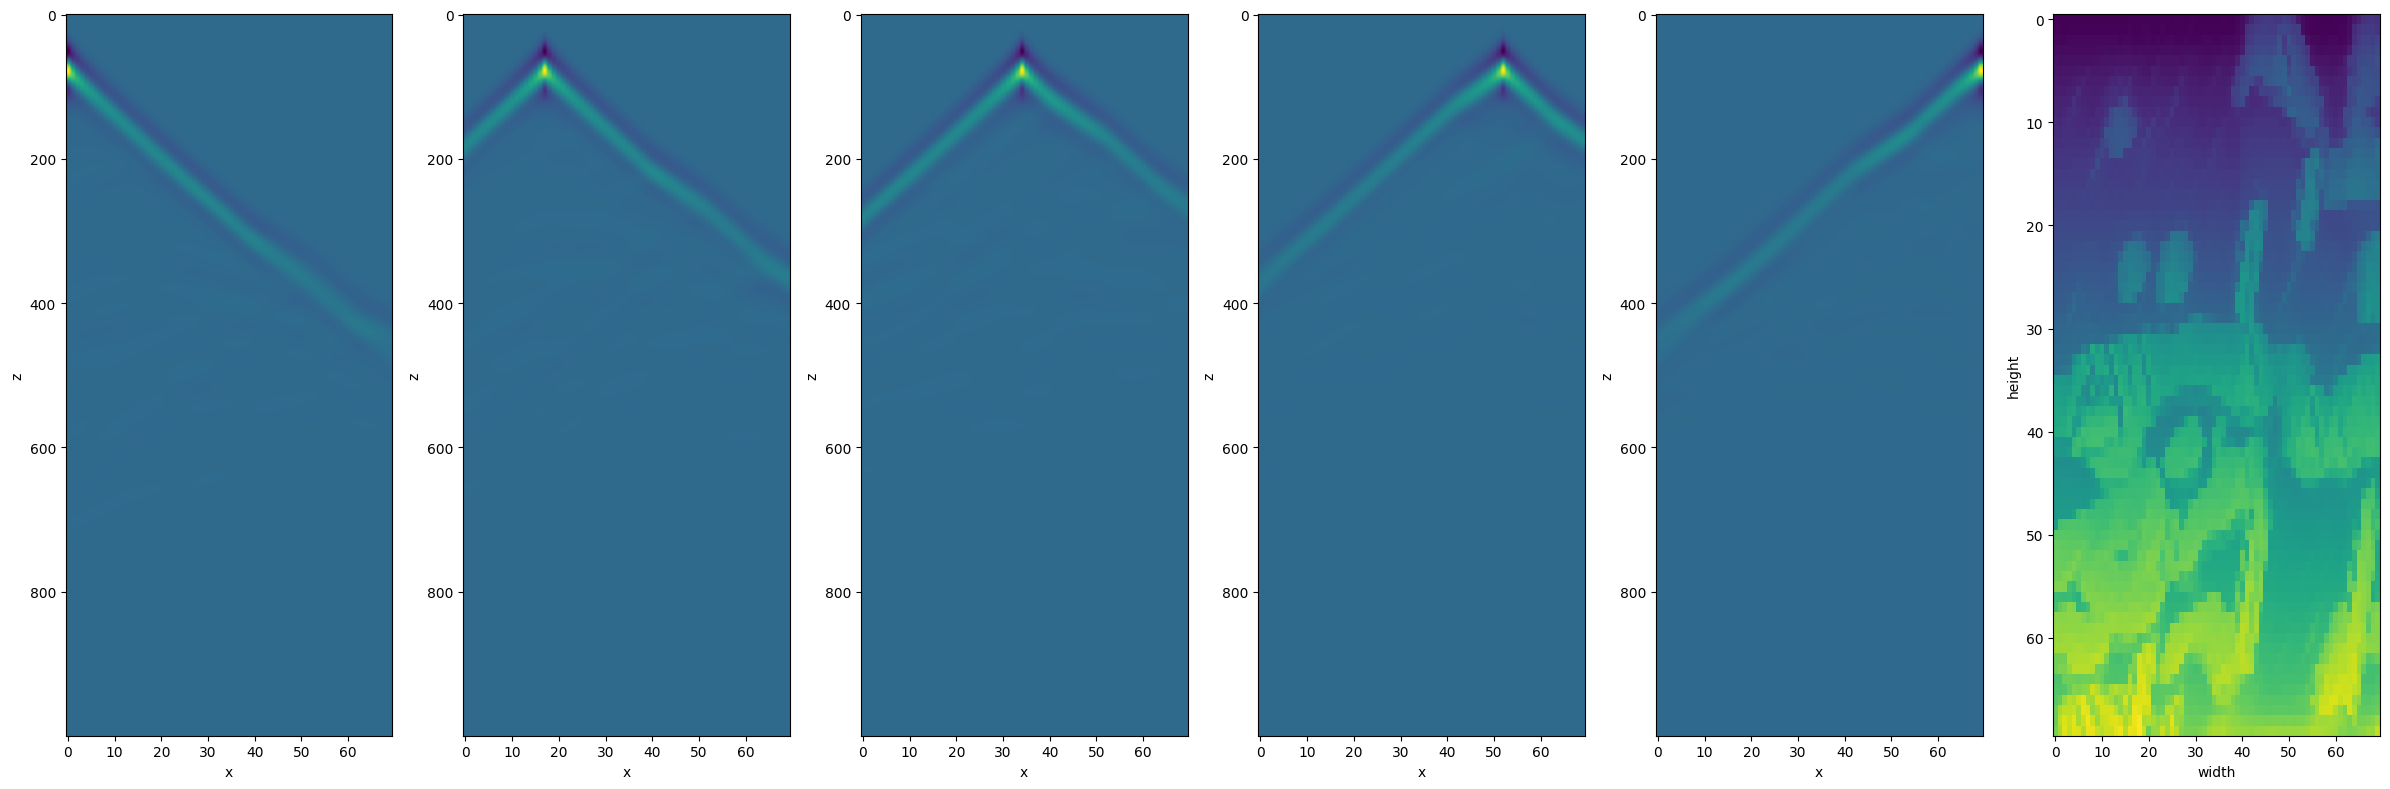

In [4]:
families = [
    "CurveFault_A",
    "CurveFault_B",
    "CurveVel_A",
    "CurveVel_B",
    "FlatFault_A",
    "FlatFault_B",
    "FlatVel_A",
    "FlatVel_B",
    "Style_A",
    "Style_B", 
]

for k in families:
    paths = [p for p in dir_path.joinpath(k).glob("*.npz")]
    random_index = np.random.randint(0, len(paths), 1).item()
    random_path = paths[random_index]
    images = np.load(random_path)
    x = images["x"]
    y = images["y"]
    print(k, random_path.stem, x.shape, y.shape)
    print(x.min(), x.max(), y.min(), y.max())

    _, axs = plt.subplots(1, 5+1, figsize=(24, 8))
    for i in range(5):
        axs[i].imshow(x[i], aspect="auto")
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("z")
    axs[5].imshow(y[0], aspect="auto")
    axs[5].set_xlabel("width")
    axs[5].set_ylabel("height")
    plt.tight_layout()
    plt.show()

### Calculate Statistics

In [5]:
def calculate_statistics(families: List[str]) -> Dict[str, float]:

    statistics = {"All": {}}
    mean_x_all = np.zeros(5)
    var_x_all = np.zeros(5)
    min_x_all = np.zeros(5)
    max_x_all = np.zeros(5)

    mean_log_x_all = np.zeros(5)
    var_log_x_all = np.zeros(5)
    min_log_x_all = np.zeros(5)
    max_log_x_all = np.zeros(5)

    mean_y_all = 0
    var_y_all = 0
    min_y_all = np.inf
    max_y_all = -np.inf

    mean_log1p_y_all = 0
    var_log1p_y_all = 0
    min_log1p_y_all = np.inf
    max_log1p_y_all = -np.inf

    num_pixels_x_all = 0
    num_pixels_y_all = 0

    for k in families:
        print(k)
        statistics[k] = {}
        paths = [p for p in dir_path.joinpath(k).glob("*.npz")]

        mean_x = np.zeros(5)
        var_x = np.zeros(5)
        min_x = np.zeros(5)
        max_x = np.zeros(5)

        mean_log_x = np.zeros(5)
        var_log_x = np.zeros(5)
        min_log_x = np.zeros(5)
        max_log_x = np.zeros(5)

        mean_y = 0
        var_y = 0
        min_y = np.inf
        max_y = -np.inf

        mean_log1p_y = 0
        var_log1p_y = 0
        min_log1p_y = np.inf
        max_log1p_y = -np.inf

        num_pixels_x = 0
        num_pixels_y = 0

        for p in tqdm(paths, total=len(paths)):
            images = np.load(p)
            x = images["x"]
            y = images["y"]
            log_x = log_transform_np(x)
            log1p_y = np.log1p(y)

            num_pixels_x += 1000 * 70
            num_pixels_y += 70 * 70

            mean_x += x.sum(axis=(1, 2))
            var_x += (x**2).sum(axis=(1, 2))
            min_x = np.minimum(min_x, x.min(axis=(1, 2)))
            max_x = np.maximum(max_x, x.max(axis=(1, 2)))

            mean_log_x += log_x.sum(axis=(1, 2))
            var_log_x += (log_x**2).sum(axis=(1, 2))
            min_log_x = np.minimum(min_log_x, log_x.min(axis=(1, 2)))
            max_log_x = np.maximum(max_log_x, log_x.max(axis=(1, 2)))

            mean_y += y.sum(axis=(0, 1, 2))
            var_y += (y**2).sum(axis=(0, 1, 2))
            min_y = np.minimum(min_y, y.min(axis=(1, 2)))
            max_y = np.maximum(max_y, y.max(axis=(1, 2)))

            mean_log1p_y += log1p_y.sum(axis=(0, 1, 2))
            var_log1p_y += (log1p_y**2).sum(axis=(0, 1, 2))
            min_log1p_y = np.minimum(min_log1p_y, log1p_y.min(axis=(1, 2)))
            max_log1p_y = np.maximum(max_log1p_y, log1p_y.max(axis=(1, 2)))

        num_pixels_x_all += num_pixels_x
        num_pixels_y_all += num_pixels_y
        mean_x_all += mean_x
        var_x_all += var_x
        mean_log_x_all += mean_log_x
        var_log_x_all += var_log_x
        mean_y_all += mean_y
        var_y_all += var_y
        mean_log1p_y_all += mean_log1p_y
        var_log1p_y_all += var_log1p_y

        mean_x /= num_pixels_x
        std_x = np.sqrt(var_x / num_pixels_x - mean_x**2)

        mean_log_x /= num_pixels_x
        std_log_x = np.sqrt(var_log_x / num_pixels_x - mean_log_x**2)

        mean_y /= num_pixels_y
        std_y = np.sqrt(var_y / num_pixels_y - mean_y**2)

        mean_log1p_y /= num_pixels_y
        std_log1p_y = np.sqrt(var_log1p_y / num_pixels_y - mean_log1p_y**2)

        statistics[k]["mean_x"] = mean_x
        statistics[k]["std_x"] = std_x
        statistics[k]["min_x"] = min_x
        statistics[k]["max_x"] = max_x

        statistics[k]["mean_log_x"] = mean_log_x
        statistics[k]["std_log_x"] = std_log_x
        statistics[k]["min_log_x"] = min_log_x
        statistics[k]["max_log_x"] = max_log_x

        statistics[k]["mean_y"] = mean_y
        statistics[k]["std_y"] = std_y
        statistics[k]["min_y"] = min_y
        statistics[k]["max_y"] = max_y

        statistics[k]["mean_log1p_y"] = mean_log1p_y
        statistics[k]["std_log1p_y"] = std_log1p_y
        statistics[k]["min_log1p_y"] = min_log1p_y
        statistics[k]["max_log1p_y"] = max_log1p_y

        min_x_all = np.minimum(min_x_all, min_x)
        max_x_all = np.maximum(max_x_all, max_x)

        min_log_x_all = np.minimum(min_log_x_all, min_log_x)
        max_log_x_all = np.maximum(max_log_x_all, max_log_x)

        min_y_all = np.minimum(min_y_all, min_y)
        max_y_all = np.maximum(max_y_all, max_y)

        min_log1p_y_all = np.minimum(min_log1p_y_all, min_log1p_y)
        max_log1p_y_all = np.maximum(max_log1p_y_all, max_log1p_y)


    mean_x_all /= num_pixels_x_all
    std_x_all = np.sqrt(var_x_all / num_pixels_x_all - mean_x_all**2)

    mean_log_x_all /= num_pixels_x_all
    std_log_x_all = np.sqrt(var_log_x_all / num_pixels_x_all - mean_log_x_all**2)

    mean_y_all /= num_pixels_y_all
    std_y_all = np.sqrt(var_y_all / num_pixels_y_all - mean_y_all**2)

    mean_log1p_y_all /= num_pixels_y_all
    std_log1p_y_all = np.sqrt(var_log1p_y_all / num_pixels_y_all - mean_log1p_y_all**2)

    statistics["All"]["mean_x"] = mean_x_all
    statistics["All"]["std_x"] = std_x_all
    statistics["All"]["mean_log_x"] = mean_log_x_all
    statistics["All"]["std_log_x"] = std_log_x_all
    statistics["All"]["mean_y"] = mean_y_all
    statistics["All"]["std_y"] = std_y_all
    statistics["All"]["mean_log1p_y"] = mean_log1p_y_all
    statistics["All"]["std_log1p_y"] = std_log1p_y_all

    return statistics

In [6]:
%%time


families = [
    "CurveFault_A",
    "CurveFault_B",
    "CurveVel_A",
    "CurveVel_B",
    "FlatFault_A",
    "FlatFault_B",
    "FlatVel_A",
    "FlatVel_B",
    "Style_A",
    "Style_B", 
]

statistics = calculate_statistics(families)
display(statistics)

with open("../output/statistics.pkl", "wb") as f:
    pickle.dump(statistics, f)

CurveFault_A


  0%|          | 0/54000 [00:00<?, ?it/s]

CurveFault_B


  0%|          | 0/54000 [00:00<?, ?it/s]

CurveVel_A


  0%|          | 0/30000 [00:00<?, ?it/s]

CurveVel_B


  0%|          | 0/30000 [00:00<?, ?it/s]

FlatFault_A


  0%|          | 0/54000 [00:00<?, ?it/s]

FlatFault_B


  0%|          | 0/54000 [00:00<?, ?it/s]

FlatVel_A


  0%|          | 0/30000 [00:00<?, ?it/s]

FlatVel_B


  0%|          | 0/30000 [00:00<?, ?it/s]

Style_A


  0%|          | 0/67000 [00:00<?, ?it/s]

Style_B


  0%|          | 0/67000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-0.00010033, -0.00010648, -0.0001097 , -0.00011381, -0.0001096 ]),
  'std_x': array([1.36988758, 1.62689213, 1.64954712, 1.62464914, 1.37684389]),
  'mean_log_x': array([-0.02712615, -0.03428732, -0.03563328, -0.03427607, -0.02741495]),
  'std_log_x': array([0.41897517, 0.46668159, 0.4751722 , 0.46597716, 0.41955682]),
  'mean_y': 2941.044579039382,
  'std_y': 813.8565966492147,
  'mean_log1p_y': 7.945855796404568,
  'std_log1p_y': 0.2923603208702152},
 'CurveFault_A': {'mean_x': array([-0.00041987, -0.00047656, -0.00049571, -0.00047432, -0.00041737]),
  'std_x': array([1.38136728, 1.64118728, 1.65858075, 1.64150242, 1.38153637]),
  'min_x': array([-26.31157112, -26.44396973, -24.90100479, -26.47726822,
         -26.37919998]),
  'max_x': array([51.61021423, 52.31136322, 48.05449677, 52.21626282, 51.58443069]),
  'mean_log_x': array([-0.02811455, -0.03608247, -0.03759107, -0.03608511, -0.02810825]),
  'std_log_x': array([0.42129935, 0.46670454, 0.47574623, 0.4

CPU times: user 1h 25min 21s, sys: 3min 48s, total: 1h 29min 10s
Wall time: 1h 41min 50s


### Calculate Statistics only A

In [7]:
%%time


families_A = [
    "CurveFault_A",
    "CurveVel_A",
    "FlatFault_A",
    "FlatVel_A",
    "Style_A",
]

statistics_A = calculate_statistics(families_A)
display(statistics_A)

with open("../output/statistics_A.pkl", "wb") as f:
    pickle.dump(statistics_A, f)

CurveFault_A


  0%|          | 0/54000 [00:00<?, ?it/s]

CurveVel_A


  0%|          | 0/30000 [00:00<?, ?it/s]

FlatFault_A


  0%|          | 0/54000 [00:00<?, ?it/s]

FlatVel_A


  0%|          | 0/30000 [00:00<?, ?it/s]

Style_A


  0%|          | 0/67000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-0.00013367, -0.00014748, -0.00015253, -0.00015094, -0.0001387 ]),
  'std_x': array([1.34955051, 1.59252695, 1.6132639 , 1.59363044, 1.35571698]),
  'mean_log_x': array([-0.02772598, -0.03483096, -0.03617273, -0.03481845, -0.02790902]),
  'std_log_x': array([0.41437726, 0.45801653, 0.46549225, 0.45806469, 0.41461142]),
  'mean_y': 2907.1943218668666,
  'std_y': 805.2824379535732,
  'mean_log1p_y': 7.934441280841732,
  'std_log1p_y': 0.2913732070883283},
 'CurveFault_A': {'mean_x': array([-0.00041987, -0.00047656, -0.00049571, -0.00047432, -0.00041737]),
  'std_x': array([1.38136728, 1.64118728, 1.65858075, 1.64150242, 1.38153637]),
  'min_x': array([-26.31157112, -26.44396973, -24.90100479, -26.47726822,
         -26.37919998]),
  'max_x': array([51.61021423, 52.31136322, 48.05449677, 52.21626282, 51.58443069]),
  'mean_log_x': array([-0.02811455, -0.03608247, -0.03759107, -0.03608511, -0.02810825]),
  'std_log_x': array([0.42129935, 0.46670454, 0.47574623, 0.

CPU times: user 43min 4s, sys: 3min 47s, total: 46min 51s
Wall time: 57min 53s


### Calculate Statistics only B

In [8]:
%%time


families_B = [
    "CurveFault_B",
    "CurveVel_B",
    "FlatFault_B",
    "FlatVel_B",
    "Style_B", 
]

statistics_B = calculate_statistics(families_B)
display(statistics_B)

with open("../output/statistics_B.pkl", "wb") as f:
    pickle.dump(statistics_B, f)

CurveFault_B


  0%|          | 0/54000 [00:00<?, ?it/s]

CurveVel_B


  0%|          | 0/30000 [00:00<?, ?it/s]

FlatFault_B


  0%|          | 0/54000 [00:00<?, ?it/s]

FlatVel_B


  0%|          | 0/30000 [00:00<?, ?it/s]

Style_B


  0%|          | 0/67000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-6.69990555e-05, -6.54784656e-05, -6.68622735e-05, -7.66913316e-05,
         -8.04884404e-05]),
  'std_x': array([1.38992713, 1.66054626, 1.68504926, 1.65508662, 1.39765149]),
  'mean_log_x': array([-0.02652632, -0.03374369, -0.03509383, -0.03373369, -0.02692087]),
  'std_log_x': array([0.42352231, 0.47518805, 0.48465825, 0.47375688, 0.42444404]),
  'mean_y': 2974.8948362118977,
  'std_y': 820.9467918940537,
  'mean_log1p_y': 7.957270311967407,
  'std_log1p_y': 0.29289961812646836},
 'CurveFault_B': {'mean_x': array([-9.75639714e-05, -8.60912607e-05, -7.88454794e-05, -9.14254801e-05,
         -9.43903416e-05]),
  'std_x': array([1.33442787, 1.60564568, 1.6179347 , 1.58433056, 1.35272404]),
  'min_x': array([-26.00320816, -26.46580505, -26.19568825, -26.07141113,
         -26.74940109]),
  'max_x': array([53.19779968, 54.00940704, 53.92480469, 54.22940445, 53.45131683]),
  'mean_log_x': array([-0.02575114, -0.03239059, -0.03321722, -0.03203476, -0.02629511]),
 

CPU times: user 43min 10s, sys: 3min 8s, total: 46min 18s
Wall time: 55min 45s


### Calculate Statistics for each family

In [6]:
%%time


families = {
    "CurveFault": ("CurveFault_A", "CurveFault_B"),
    "CurveVel": ("CurveVel_A", "CurveVel_B"),
    "FlatFault": ("FlatFault_A", "FlatFault_B"),
    "FlatVel": ("FlatVel_A", "FlatVel_B"),
    "Style": ("Style_A", "Style_B"),
}

for k, f_AB in families.items():
    statistics_AB = calculate_statistics(f_AB)
    display(statistics_AB)

    with open(f"../output/statistics_{k}.pkl", "wb") as f:
        pickle.dump(statistics_AB, f)

CurveFault_A


  0%|          | 0/54000 [00:00<?, ?it/s]

CurveFault_B


  0%|          | 0/54000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-0.00025872, -0.00028133, -0.00028728, -0.00028287, -0.00025588]),
  'std_x': array([1.3581004 , 1.62351375, 1.63838379, 1.61316979, 1.36720611]),
  'mean_log_x': array([-0.02693285, -0.03423653, -0.03540415, -0.03405993, -0.02720168]),
  'std_log_x': array([0.41843325, 0.4690404 , 0.47828122, 0.46761192, 0.42138262]),
  'mean_y': 3059.2206754686317,
  'std_y': 871.873888578889,
  'mean_log1p_y': 7.981239591069066,
  'std_log1p_y': 0.30875591876561276},
 'CurveFault_A': {'mean_x': array([-0.00041987, -0.00047656, -0.00049571, -0.00047432, -0.00041737]),
  'std_x': array([1.38136728, 1.64118728, 1.65858075, 1.64150242, 1.38153637]),
  'min_x': array([-26.31157112, -26.44396973, -24.90100479, -26.47726822,
         -26.37919998]),
  'max_x': array([51.61021423, 52.31136322, 48.05449677, 52.21626282, 51.58443069]),
  'mean_log_x': array([-0.02811455, -0.03608247, -0.03759107, -0.03608511, -0.02810825]),
  'std_log_x': array([0.42129935, 0.46670454, 0.47574623, 0.

CurveVel_A


  0%|          | 0/30000 [00:00<?, ?it/s]

CurveVel_B


  0%|          | 0/30000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-0.00014123, -0.0001543 , -0.00015973, -0.00015557, -0.00013612]),
  'std_x': array([1.46078336, 1.73042319, 1.75305612, 1.72927481, 1.45624254]),
  'mean_log_x': array([-0.02778117, -0.03500902, -0.03627846, -0.03490803, -0.0282714 ]),
  'std_log_x': array([0.44071149, 0.48711709, 0.49490913, 0.48465832, 0.43071154]),
  'mean_y': 2894.0034611734695,
  'std_y': 837.6539434650587,
  'mean_log1p_y': 7.9263898998458755,
  'std_log1p_y': 0.3030717405495907},
 'CurveVel_A': {'mean_x': array([-5.67862378e-05, -5.30428068e-05, -5.01289425e-05, -4.99852740e-05,
         -4.48651143e-05]),
  'std_x': array([1.33074463, 1.56526418, 1.58745956, 1.57359466, 1.35574384]),
  'min_x': array([-26.66196442, -26.66210938, -26.66210938, -26.6724205 ,
         -27.10528183]),
  'max_x': array([52.11060715, 52.12663269, 52.12748337, 52.10651779, 55.07283401]),
  'mean_log_x': array([-0.02681353, -0.0335481 , -0.0346661 , -0.03346392, -0.0276863 ]),
  'std_log_x': array([0.41230035

FlatFault_A


  0%|          | 0/54000 [00:00<?, ?it/s]

FlatFault_B


  0%|          | 0/54000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-0.00026378, -0.0002858 , -0.00029234, -0.00028766, -0.00026268]),
  'std_x': array([1.35865785, 1.60763333, 1.63040399, 1.60839223, 1.36262753]),
  'mean_log_x': array([-0.02741568, -0.03433837, -0.03579182, -0.03448284, -0.0275489 ]),
  'std_log_x': array([0.41778809, 0.4632824 , 0.47138512, 0.462981  , 0.41933823]),
  'mean_y': 3072.326278781179,
  'std_y': 865.6349365078117,
  'mean_log1p_y': 7.98643255838707,
  'std_log1p_y': 0.30577765148410646},
 'FlatFault_A': {'mean_x': array([-0.0003996 , -0.00045381, -0.00047302, -0.0004536 , -0.00039792]),
  'std_x': array([1.38283945, 1.63239596, 1.65289981, 1.63215064, 1.38288796]),
  'min_x': array([-25.81138229, -25.62724113, -25.62722206, -25.80281067,
         -26.09235191]),
  'max_x': array([50.73881912, 49.80880737, 49.83499527, 50.27861023, 50.85504532]),
  'mean_log_x': array([-0.02897607, -0.03611467, -0.03757391, -0.03610468, -0.02897995]),
  'std_log_x': array([0.42350123, 0.46590964, 0.47294168, 0.46

FlatVel_A


  0%|          | 0/30000 [00:00<?, ?it/s]

FlatVel_B


  0%|          | 0/30000 [00:00<?, ?it/s]

{'All': {'mean_x': array([-0.00012331, -0.00013762, -0.00014256, -0.00013763, -0.0001233 ]),
  'std_x': array([1.46952024, 1.7347478 , 1.75655789, 1.73474781, 1.46952025]),
  'mean_log_x': array([-0.0288993 , -0.03593034, -0.03715525, -0.03593035, -0.02889929]),
  'std_log_x': array([0.44321505, 0.48597349, 0.49262674, 0.48597349, 0.44321505]),
  'mean_y': 2891.691481190476,
  'std_y': 834.6229703101527,
  'mean_log1p_y': 7.925844271537521,
  'std_log1p_y': 0.3022059554709123},
 'FlatVel_A': {'mean_x': array([-3.62219817e-05, -3.30736078e-05, -3.04417169e-05, -3.30905501e-05,
         -3.61936015e-05]),
  'std_x': array([1.3331209 , 1.564293  , 1.58067554, 1.564293  , 1.33312091]),
  'min_x': array([-26.94063568, -26.94098663, -26.94098663, -26.94098663,
         -26.94063568]),
  'max_x': array([52.76977539, 52.7657547 , 52.7657547 , 52.7657547 , 52.76977539]),
  'mean_log_x': array([-0.02743865, -0.03397653, -0.03506703, -0.03397654, -0.02743863]),
  'std_log_x': array([0.41251976, 0

Style_A


  0%|          | 0/67000 [00:00<?, ?it/s]

Style_B


  0%|          | 0/67000 [00:00<?, ?it/s]

{'All': {'mean_x': array([0.00018765, 0.00021432, 0.00021775, 0.00019192, 0.0001497 ]),
  'std_x': array([1.29820102, 1.54526803, 1.57489295, 1.54566125, 1.31512997]),
  'mean_log_x': array([-0.02596135, -0.0332283 , -0.03471981, -0.03325993, -0.02643075]),
  'std_log_x': array([0.39872105, 0.44900036, 0.45842086, 0.44907711, 0.40193231]),
  'mean_y': 2783.1506309529345,
  'std_y': 654.4957955634782,
  'mean_log1p_y': 7.9023103125812,
  'std_log1p_y': 0.24699137016353423},
 'Style_A': {'mean_x': array([0.00023328, 0.00027112, 0.00028184, 0.00025567, 0.0002069 ]),
  'std_x': array([1.31158352, 1.54406893, 1.56919321, 1.54420989, 1.32219755]),
  'min_x': array([-24.839077  , -24.95943069, -24.72951508, -24.75992203,
         -24.8397007 ]),
  'max_x': array([48.40392303, 48.67458344, 48.92686081, 48.54954529, 48.49643707]),
  'mean_log_x': array([-0.02694248, -0.03374466, -0.03506997, -0.03374438, -0.02719566]),
  'std_log_x': array([0.40291304, 0.44841816, 0.45592418, 0.44839175, 0.4047

CPU times: user 1h 24min 51s, sys: 3min 20s, total: 1h 28min 11s
Wall time: 1h 41min 23s
